In [1]:
from torch import empty
import math
from FC_module import LossMSE, ReLU, Tanh, Sigmoid, FCC, Sequential

In [2]:
train_size = 1000
test_size = 200
valid_size = 100
train_input = empty(train_size, 2).uniform_(0,1)
train_target = train_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

valid_input = empty(valid_size, 2).uniform_(0,1)
valid_target = valid_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

test_input = empty(test_size, 2).uniform_(0,1)
test_target = test_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

[Go to Benchamrking](#Benchmarking) with Pytorch

### These two are just for a quick check I know they are terrible :D

In [43]:
def accuracy_count(pred,true):
    pred = (pred > 0.5).long().view(-1)
    true = true.long().view(-1)
    return (pred.size(0) - (pred-true).abs().sum()).item()

In [5]:
import torch
import matplotlib.pyplot as plt

In [46]:
def modelTrainer(train_input,train_target,test_input,test_target,test_size):
    seq = Sequential(["FCC","ReLU","FCC"],[[2,8],[], [8,1]],"MSE")
    loss_track = []
    for epoch in range(1000):
        minibatch = 200
        for i in range(0, train_input.size(0), minibatch):
            out,loss = seq.train(train_input.narrow(0, i, minibatch), train_target.narrow(0, i, minibatch).unsqueeze(1))
        if epoch %200 == 0:
            print("Loss:", loss.item())
        loss_track.append(loss)
    plt.figure()
    plt.plot(loss_track)
    print("---------------------------------")
    acc = 0
    count = 0
    minibatch = 10
    for i in range(0, test_size, minibatch):
        truth = test_target.narrow(0, i, minibatch)
        inp = test_input.narrow(0, i, minibatch)
        out = seq.eval(inp)
        #print(out)
        acc += accuracy_count(out, truth)
    
    return seq, acc/test_size

Loss: 0.3694192171096802
Loss: 0.20595644414424896
Loss: 0.16240890324115753
Loss: 0.13950102031230927
Loss: 0.1157323569059372
---------------------------------
0.93
Loss: 0.3195362985134125
Loss: 0.23245945572853088
Loss: 0.21552135050296783
Loss: 0.19764751195907593
Loss: 0.18241921067237854
---------------------------------
0.7
Loss: 0.5633994936943054
Loss: 0.2168140411376953
Loss: 0.1930060237646103
Loss: 0.17177481949329376
Loss: 0.13692238926887512
---------------------------------
0.84
Loss: 0.26222485303878784
Loss: 0.24761924147605896
Loss: 0.24768666923046112
Loss: 0.24772287905216217
Loss: 0.24768194556236267
---------------------------------
0.41
Loss: 0.42137831449508667
Loss: 0.24755913019180298
Loss: 0.2477419227361679
Loss: 0.24777379631996155
Loss: 0.24776914715766907
---------------------------------
0.38
Loss: 0.5786001682281494
Loss: 0.24509550631046295
Loss: 0.2275298535823822
Loss: 0.20281614363193512
Loss: 0.17342136800289154
---------------------------------
0

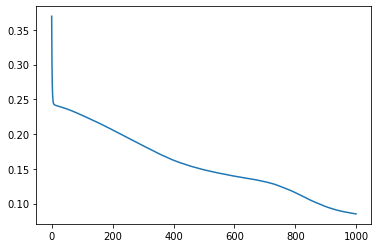

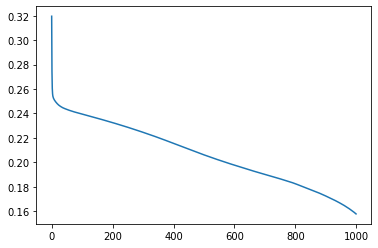

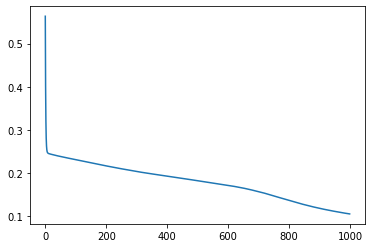

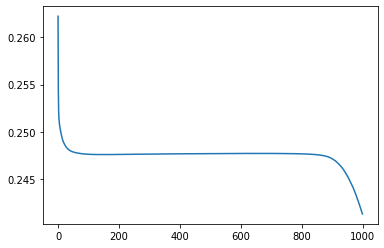

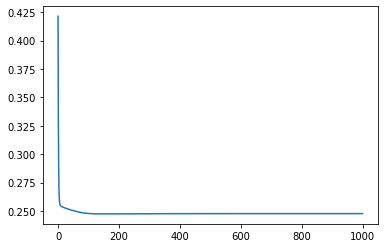

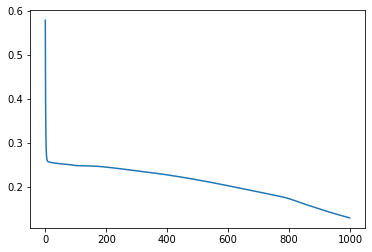

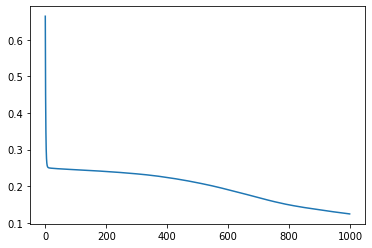

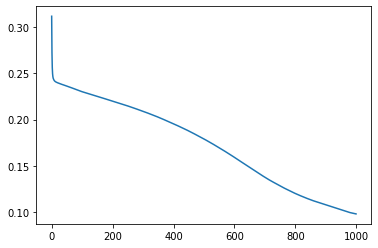

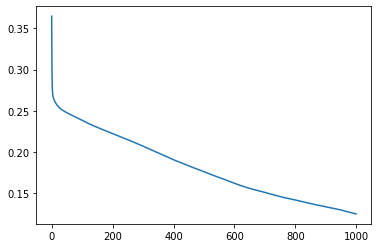

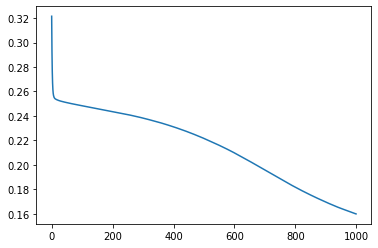

In [47]:
train_size = 1000
test_size = 200
valid_size = 100
train_input = empty(train_size, 2).uniform_(0,1)
train_target = train_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

valid_input = empty(valid_size, 2).uniform_(0,1)
valid_target = valid_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

test_input = empty(test_size, 2).uniform_(0,1)
test_target = test_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)



models = []
best_acc = 0
curr_acc = 0
best_idx = -1
for idx in range(10):    
    model, curr_acc = modelTrainer(train_input,train_target,valid_input,valid_target,valid_size) 
    models.append(model)
    if (curr_acc > best_acc):
        best_acc = curr_acc
        best_idx = idx
    print(curr_acc)



In [8]:
best_idx

0

In [9]:
test_target

tensor([1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 0.])

### Benchmarking

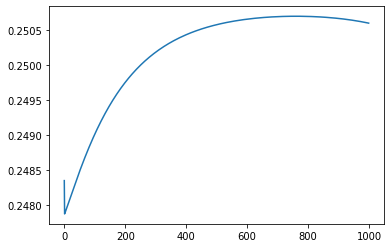

In [12]:
from torch import optim, Tensor, nn
from torch import Tensor
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.set_grad_enabled(True)

def create_model():
    return nn.Sequential(
        nn.Linear(2, 8),
        nn.Sigmoid(),
        nn.Linear(8, 1),
#         nn.ReLU(),
    )

def train_model(model, train_input, train_target):
    loss_track = []
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.1)
    mini_batch = 200
    # Iterate through epochs
    for i in range(1000):
        #Iterate t hrough mini batches
        for b in range(0, train_input.size(0), mini_batch):
            # Forward pass selecting the corresponding minibacth
            output = model(train_input.narrow(0, b, mini_batch))
            # Calculate loss
            loss = loss_func(output.squeeze(), train_target.narrow(0, b, mini_batch))
#             print("Loss:", loss.item())
            # Reset zero grad
            model.zero_grad()
            # Backward pass
            loss.backward()
            #Update step
            optimizer.step()
        loss_track.append(loss)
    plt.plot(loss_track)
    
def compute_nb_errors(model, data_input, data_target):
        output = model(data_input)
        comp = output.argmax(dim = 1) != data_target.argmax(dim = 1)
        nb_errors = torch.where(comp)[0].size()[0]
        error_rate = nb_errors/data_input.size(0)
        print(f'There were a total of {nb_errors} errors, or {error_rate} of the testing set.')
        
        
model = create_model()
train_model(model, train_input, train_target)
# compute_nb_errors(model, test_input, test_target)